<a href="https://colab.research.google.com/github/jonie20/jonie20/blob/master/Copy_of_ForexEURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#ignoring warnings
import warnings
warnings.simplefilter('ignore')

#importing neccesary modules
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sklearn
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split

import xgboost
from xgboost import XGBRegressor, DMatrix

In [4]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install -q kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jonie20","key":"205f9c6efd9a4c5af6a47468ccc5e3f8"}'}

In [7]:
!mkdir ~/.kaggle

In [8]:
!cp kaggle.json ~/.kaggle/

In [9]:
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
!kaggle datasets download -d maheshtaank/eurusd-daily

  0% 0.00/171k [00:00<?, ?B/s]
100% 171k/171k [00:00<00:00, 110MB/s]


In [11]:
!unzip eurusd-daily.zip

Archive:  eurusd-daily.zip
  inflating: eu.csv                  


In [12]:
eu = pd.read_csv('/content/eu.csv', index_col=0, parse_dates=True, skipinitialspace=True)
eu.drop('date', axis='columns', inplace=True)
eu.head(2)

,open,high,low,close,volume
1971-01-04,0.5369,0.5369,0.5369,0.5369,1
1971-01-05,0.5366,0.5366,0.5366,0.5366,1


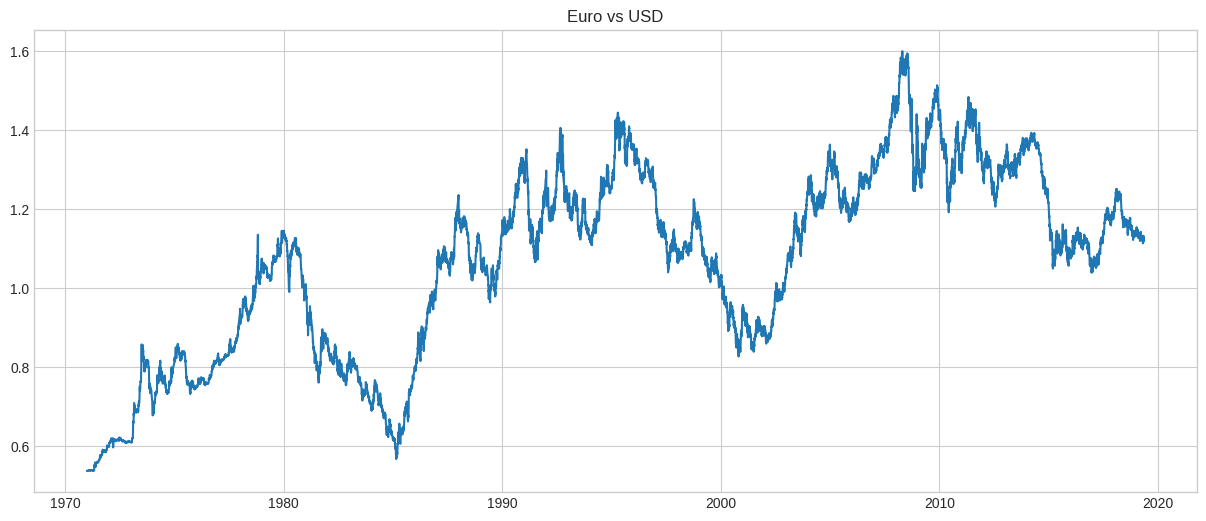

In [13]:
plt.figure(figsize=(15,6))
plt.plot(eu.close)
plt.title('Euro vs USD')
plt.legend()
plt.show()

<Axes: >

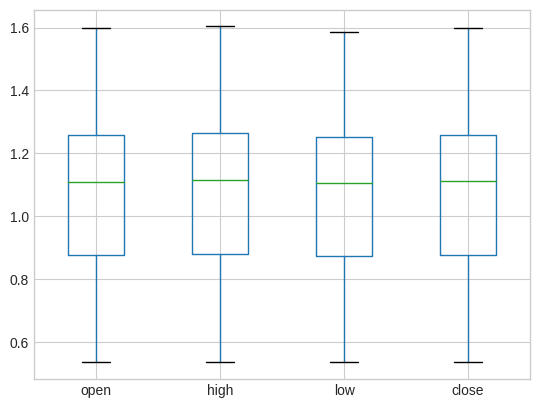

In [14]:
#box plot for open, high, low , close
eu.drop('volume', axis=1).boxplot()

In [15]:
#removing outliers above
vol_cut_off = eu.volume.std()*3 + eu.volume.mean()
eu.volume[eu.volume > vol_cut_off] = vol_cut_off

In [16]:
#removing ouliers below
vol_cut_off =  eu.volume.mean() - eu.volume.std()*3
eu.volume[eu.volume < vol_cut_off] = vol_cut_off

<Axes: >

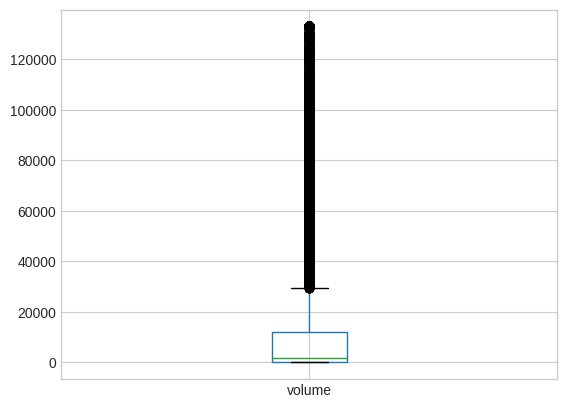

In [17]:
#boxplot for volume
eu[['volume']].boxplot()

In [18]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_905_'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    #average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    #standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()
    
    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

data = generate_features(eu)

In [19]:
data.head()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
1972-05-24,0.6156,0.6154,0.6153,0.6154,0.6151,51.0,0.61502,0.615143,0.615479,0.588782,...,2.0,0.000325,0.002281,-0.000812,0.000488,0.143043,0.000456,0.000027,0.000539,0.6156
1972-05-25,0.6147,0.6156,0.6156,0.6156,0.6156,1.0,0.61516,0.615152,0.615530,0.589088,...,2.0,0.000488,0.001138,0.000325,0.005225,0.143388,0.000228,0.000102,0.000540,0.6147
1972-05-26,0.6153,0.6147,0.6147,0.6147,0.6147,1.0,0.61508,0.615133,0.615551,0.589391,...,2.0,-0.001462,-0.000650,-0.000650,0.002119,0.141504,-0.000130,0.000053,0.000534,0.6153
1972-05-30,0.6159,0.6153,0.6153,0.6153,0.6153,1.0,0.61520,0.615129,0.615557,0.589695,...,2.0,0.000976,0.000976,-0.000162,0.000651,0.142194,0.000196,0.000029,0.000536,0.6159
1972-05-31,0.6157,0.6159,0.6159,0.6159,0.6159,1.0,0.61536,0.615171,0.615573,0.589970,...,2.0,0.000975,0.001301,0.001463,0.001626,0.126990,0.000260,0.000045,0.000482,0.6157


In [20]:
data.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,...,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000,11767.000000
mean,1.086889,1.086844,1.086888,1.090879,1.082889,20020.133291,1.086797,1.086449,1.085553,1.081166,...,0.883685,0.000073,0.000376,0.001563,0.004832,0.021705,0.000075,0.000072,0.000078,1.086932
std,0.222157,0.222199,0.222193,0.224191,0.220211,34864.604675,0.222185,0.222203,0.222170,0.222008,...,0.330712,0.006481,0.014627,0.031606,0.057078,0.123582,0.002924,0.000903,0.000474,0.222150
min,0.567200,0.567200,0.567200,0.568600,0.563300,1.000000,0.574540,0.580143,0.601424,0.588782,...,0.044556,-0.056418,-0.095796,-0.147266,-0.200039,-0.325111,-0.019757,-0.003489,-0.001531,0.567200
25%,0.900350,0.900250,0.900250,0.904500,0.896000,291.000000,0.899140,0.900474,0.898065,0.895435,...,0.653606,-0.003369,-0.008224,-0.017772,-0.032832,-0.072582,-0.001633,-0.000511,-0.000279,0.900300
50%,1.118540,1.118530,1.118710,1.122670,1.114100,2061.000000,1.119168,1.118103,1.113353,1.110729,...,0.877846,0.000000,0.000163,0.000551,0.003370,0.014574,0.000050,0.000071,0.000079,1.118780
75%,1.263200,1.263200,1.263240,1.269350,1.256550,12350.000000,1.263140,1.263681,1.267417,1.254438,...,1.083331,0.003435,0.008761,0.020236,0.041607,0.098024,0.001765,0.000670,0.000392,1.263240
max,1.599500,1.599500,1.599700,1.603800,1.586600,132937.440396,1.591080,1.579900,1.564808,1.506541,...,2.000000,0.062078,0.106059,0.159589,0.245135,0.536577,0.020409,0.003513,0.001741,1.599700


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11767 entries, 1972-05-24 to 2019-05-09
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     11767 non-null  float64
 1   open_1                   11767 non-null  float64
 2   close_1                  11767 non-null  float64
 3   high_1                   11767 non-null  float64
 4   low_1                    11767 non-null  float64
 5   volume_1                 11767 non-null  float64
 6   avg_price_5              11767 non-null  float64
 7   avg_price_30             11767 non-null  float64
 8   avg_price_90             11767 non-null  float64
 9   avg_price_365            11767 non-null  float64
 10  ratio_avg_price_5_30     11767 non-null  float64
 11  ratio_avg_price_905_     11767 non-null  float64
 12  ratio_avg_price_5_365    11767 non-null  float64
 13  ratio_avg_price_30_90    11767 non-null  float64
 14  ratio

<Axes: >

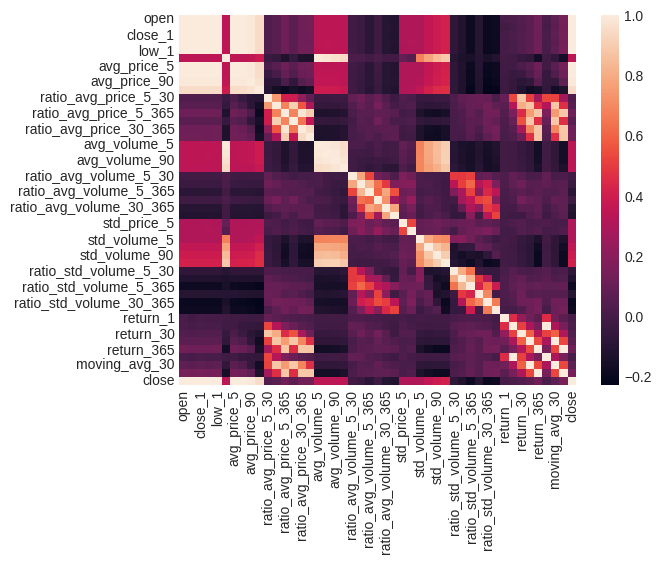

In [22]:
sns.heatmap(data.corr())

In [23]:
#import datetime module
import datetime

#segregate data for training
start_train = datetime.datetime(1999, 1, 1,0,0)
end_train = datetime.datetime(2017, 12, 31, 0, 0)
data_train = data.loc[start_train:end_train]
data_train.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,...,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000,4927.000000
mean,1.208151,1.208147,1.208187,1.213862,1.202455,40686.728025,1.208176,1.208145,1.208200,1.207694,...,0.817169,0.000023,0.000129,0.000435,0.001137,0.005678,0.000027,0.000018,0.000022,1.208193
std,0.172870,0.172872,0.172826,0.173393,0.172278,40294.793603,0.172700,0.172263,0.171001,0.165122,...,0.323432,0.006325,0.013731,0.028680,0.050306,0.101442,0.002746,0.000802,0.000401,0.172824
min,0.827200,0.827200,0.826700,0.832600,0.822700,1.000000,0.833560,0.849195,0.858429,0.883636,...,0.197396,-0.026604,-0.065191,-0.147266,-0.200039,-0.241870,-0.013307,-0.003489,-0.001086,0.826700
25%,1.086675,1.086675,1.086455,1.091565,1.080790,9047.500000,1.086354,1.085491,1.093947,1.102588,...,0.574596,-0.003710,-0.008518,-0.017549,-0.033530,-0.071997,-0.001689,-0.000516,-0.000277,1.086455
50%,1.233210,1.233210,1.233200,1.238890,1.226510,13729.000000,1.232880,1.231542,1.238760,1.241315,...,0.777042,0.000110,0.000245,-0.000190,0.003050,0.008993,0.000065,0.000070,0.000055,1.233200
75%,1.336285,1.336285,1.336385,1.341200,1.330500,68608.500000,1.335869,1.333910,1.331287,1.343072,...,1.016169,0.003522,0.009036,0.018362,0.034959,0.076567,0.001816,0.000563,0.000308,1.336385
max,1.599500,1.599500,1.599700,1.603800,1.586600,132937.440396,1.591080,1.579900,1.564808,1.506541,...,1.942073,0.034903,0.106059,0.141554,0.140802,0.260726,0.020409,0.002134,0.000938,1.599700


In [24]:
#segregate data for validation
start_test = datetime.datetime(2018, 1, 1, 0, 0)
end_test = datetime.datetime(2019, 6, 7, 0, 0)
data_test = data.loc[start_test:end_test]
data_test.describe()

,open,open_1,close_1,high_1,low_1,volume_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,...,ratio_std_volume_90_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,close
count,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,...,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,1.168335,1.168551,1.168404,1.172679,1.164774,85860.709055,1.168790,1.170189,1.173200,1.175544,...,0.785246,-0.000176,-0.000785,-0.002987,-0.007239,0.014224,-0.000156,-0.000114,0.000052,1.168174
std,0.038680,0.038614,0.038646,0.039068,0.038099,28427.264667,0.038265,0.036942,0.033194,0.017669,...,0.234142,0.004373,0.009027,0.016337,0.030892,0.086742,0.001806,0.000491,0.000332,0.038700
min,1.113220,1.113220,1.113130,1.116200,1.111050,698.000000,1.116498,1.122836,1.127743,1.131791,...,0.430578,-0.019107,-0.022843,-0.046899,-0.067556,-0.094090,-0.004603,-0.001100,-0.000383,1.113130
25%,1.136580,1.136750,1.136570,1.140910,1.133530,64344.000000,1.136546,1.137379,1.139820,1.161746,...,0.569664,-0.002896,-0.007221,-0.011647,-0.025809,-0.054522,-0.001444,-0.000410,-0.000213,1.136550
50%,1.158720,1.158740,1.159300,1.162750,1.154300,79792.000000,1.161040,1.162870,1.162962,1.181830,...,0.757015,-0.000070,-0.001085,-0.003310,-0.011099,-0.017814,-0.000203,-0.000170,-0.000062,1.158770
75%,1.195030,1.195030,1.195030,1.200880,1.192600,107336.000000,1.197898,1.198645,1.202718,1.190621,...,0.953143,0.002727,0.005213,0.004623,0.005808,0.100285,0.001050,0.000101,0.000389,1.194740
max,1.250730,1.250730,1.250780,1.255540,1.244800,132937.440396,1.243208,1.237799,1.234132,1.195315,...,1.303164,0.014013,0.027068,0.045857,0.073182,0.185276,0.005369,0.001130,0.000685,1.250780


In [25]:
X_train = data_train.drop('close', axis='columns')
y_train = data_train.close

X_test = data_test.drop('close', axis='columns')
y_test = data_test.close

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4927, 46), (349, 46), (4927,), (349,))

In [26]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [27]:
from sklearn.linear_model import LinearRegression
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.005
MAE: 0.004
R^2: 0.983


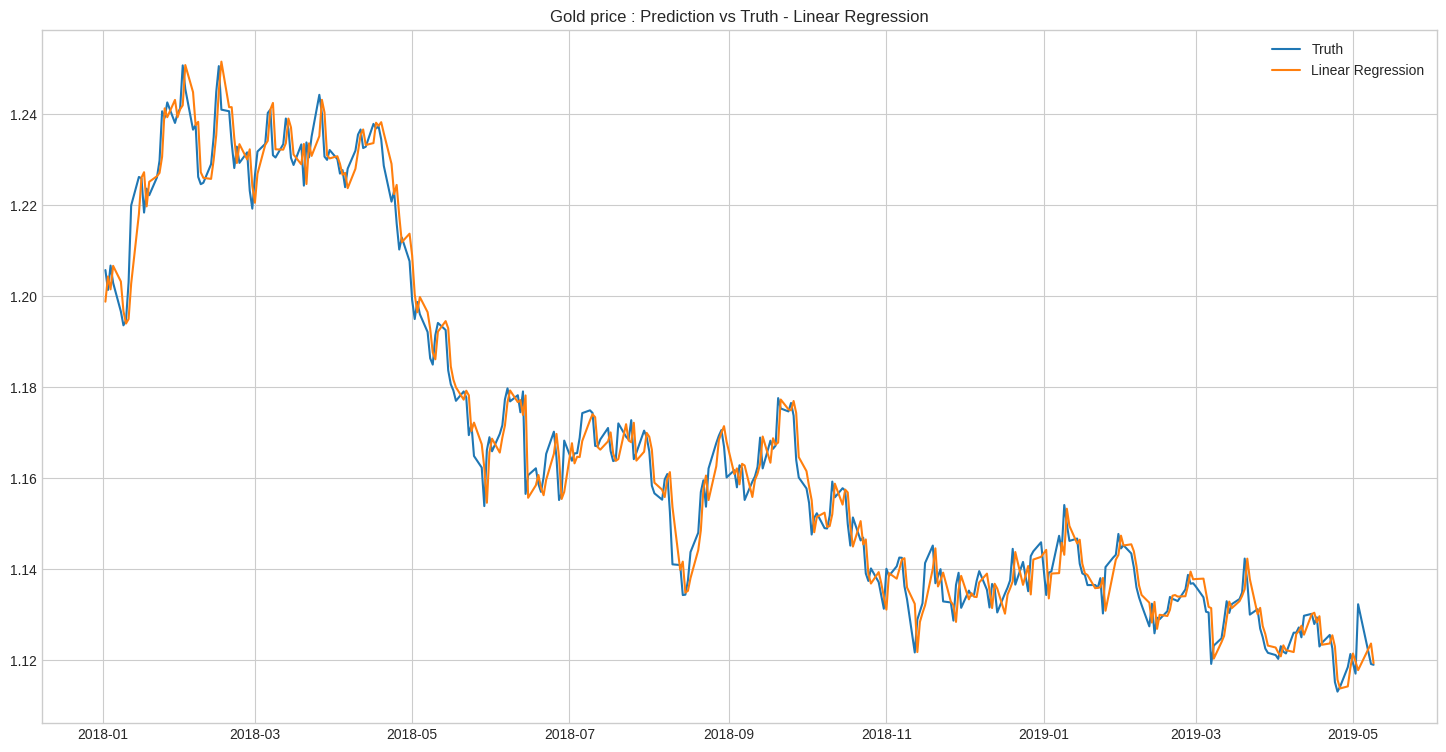

In [28]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plt.style.use('seaborn-whitegrid')
plot_truth, = plt.plot(dates, y_test)
plot_lin, = plt.plot(dates, predictions_lin)
plt.legend([plot_truth, plot_lin], ['Truth', 'Linear Regression'])
plt.title('Gold price : Prediction vs Truth - Linear Regression')
plt.show()

In [29]:
# First experiment with linear regression

# SGD is very sensitive to data with features at different scales. Hence we need to do feature scaling before training.
#search for the SGD-based linear regression with the optimal set of parameters. 
from sklearn.linear_model import SGDRegressor

param_grid = {
    'penalty':['l1', 'l2', 'elasticnet'],
    "alpha": [1e-5, 3e-5, 1e-4],
    "eta0": [0.01, 0.03, 0.1],
}

sgd = SGDRegressor()
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_scaled_train, y_train)

print(grid_search.best_params_)

sgd_best = grid_search.best_estimator_
#print(grid_search.best_score_)

predictions_sgd = sgd_best.predict(X_scaled_test)

#evaluating the predictions
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_sgd)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_sgd)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_sgd)))

{'alpha': 0.0001, 'eta0': 0.03, 'penalty': 'l1'}
RMSE: 0.006
MAE: 0.004
R^2: 0.978


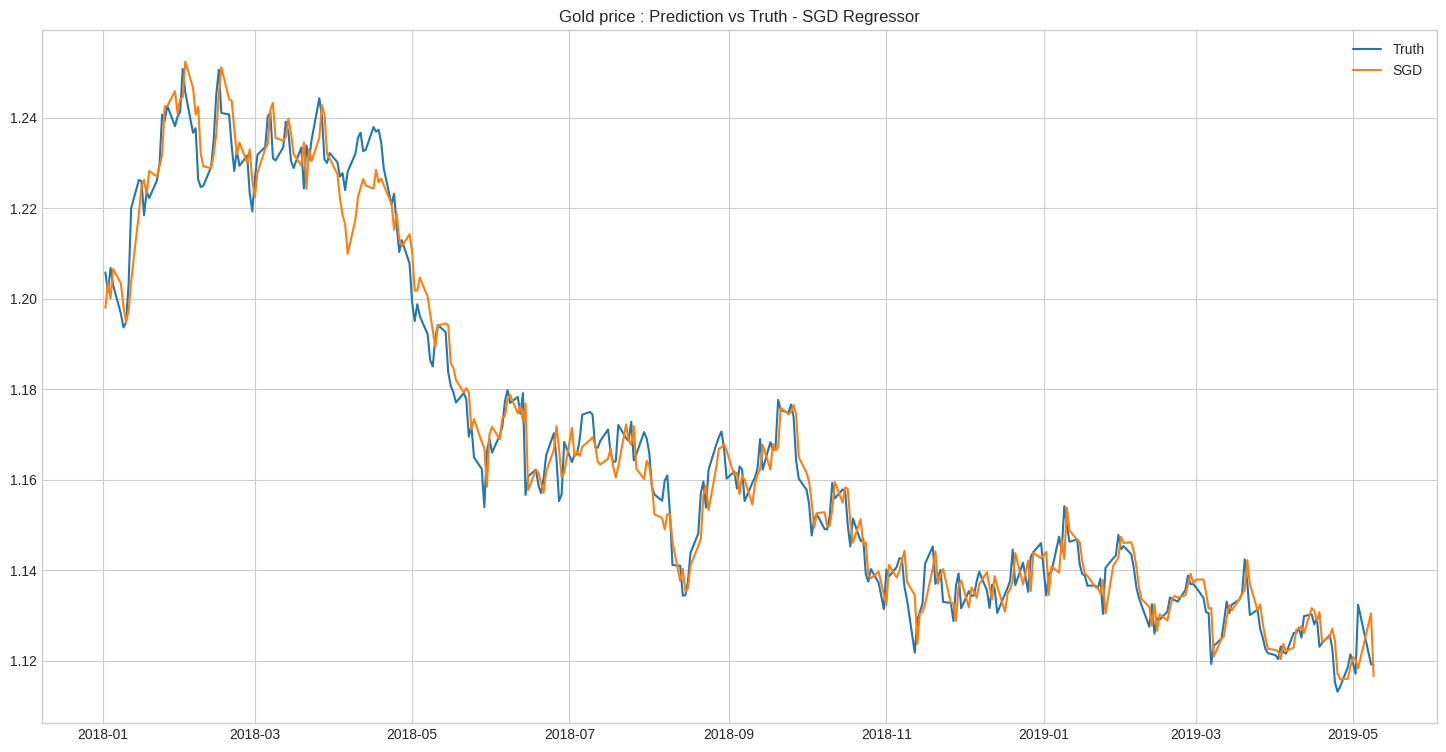

In [30]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_sgd, = plt.plot(dates, predictions_sgd)
plt.legend([plot_truth, plot_sgd], ['Truth', 'SGD'])
plt.title('Gold price : Prediction vs Truth - SGD Regressor')
plt.style.use('seaborn-whitegrid')
plt.show()

In [31]:
xgb = XGBRegressor()

data_dmatrix = DMatrix(data=X_train,
                           label=y_train)

xgb_param_grid = {'learning_rate': [0.001, 0.01, 0.1, 1],
                  'n_estimators': [50, 100, 200, 300],
                  'subsample': [0.3, 0.5, 0.7, 1]}

grid_search = GridSearchCV(estimator=xgb,    
                        param_grid=xgb_param_grid,
                        scoring='neg_mean_squared_error', 
                        cv=4, 
                        verbose=1,
                       n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best parameters found: ",grid_search.best_params_)

xgb_best = grid_search.best_estimator_

xgb_best.fit(X_train,y_train)
predictions_xgb = xgb_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_xgb)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_xgb)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_xgb)))

Fitting 4 folds for each of 64 candidates, totalling 256 fits
Best parameters found:  {'learning_rate': 0.1, 'n_estimators': 50, 'subsample': 0.5}
RMSE: 0.007
MAE: 0.006
R^2: 0.966


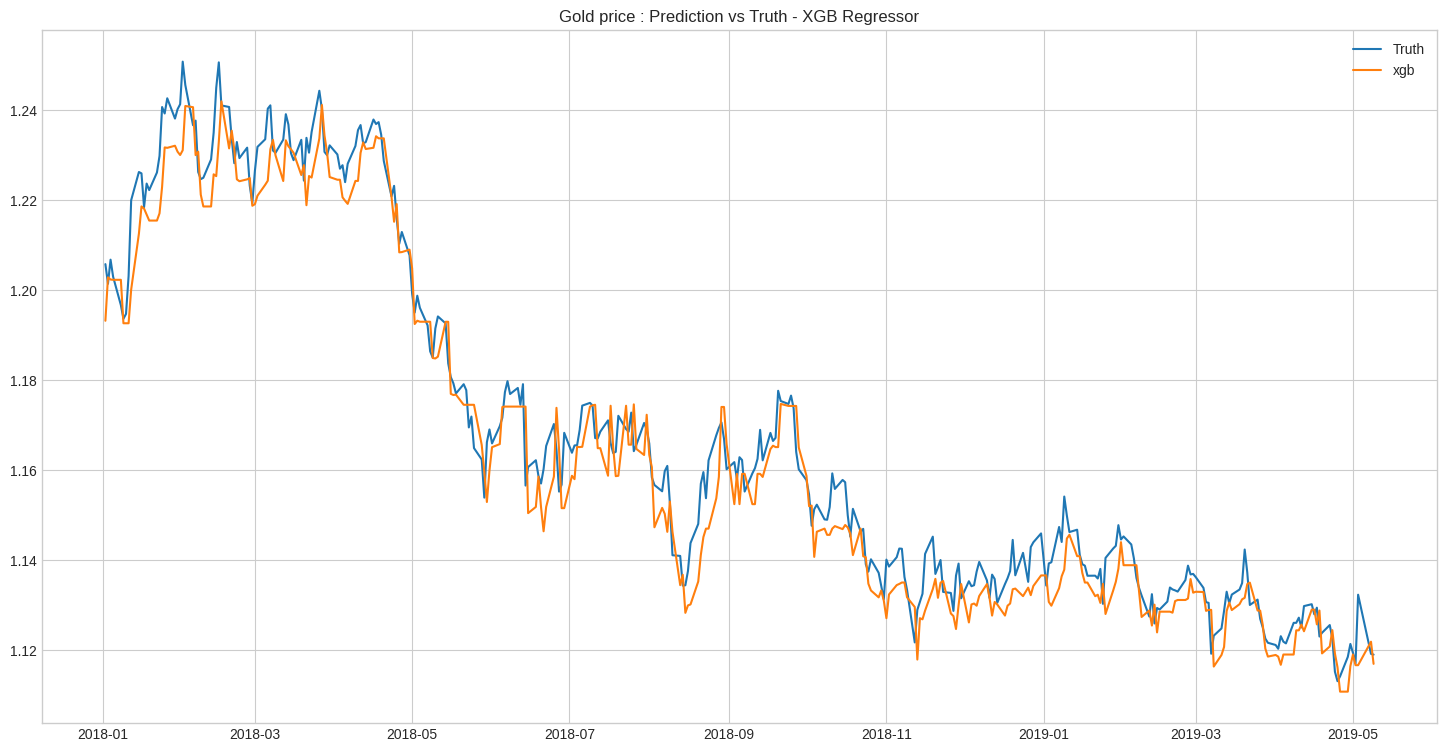

In [32]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_xgb, = plt.plot(dates, predictions_xgb)
plt.legend([plot_truth, plot_xgb], ['Truth', 'xgb'])
plt.title('Gold price : Prediction vs Truth - XGB Regressor')
plt.show()

In [33]:
BaggingRegressor?

In [34]:
bgr = BaggingRegressor(base_estimator=lin, n_estimators=100, oob_score=True, n_jobs=-1)

bgr.fit(X_scaled_train, y_train)
predictions_bgr = bgr.predict(X_scaled_test)

print('OOB: {0:.3f}'.format(bgr.oob_score))
print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_bgr)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_bgr)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_bgr)))

OOB: 1.000
RMSE: 0.005
MAE: 0.004
R^2: 0.983


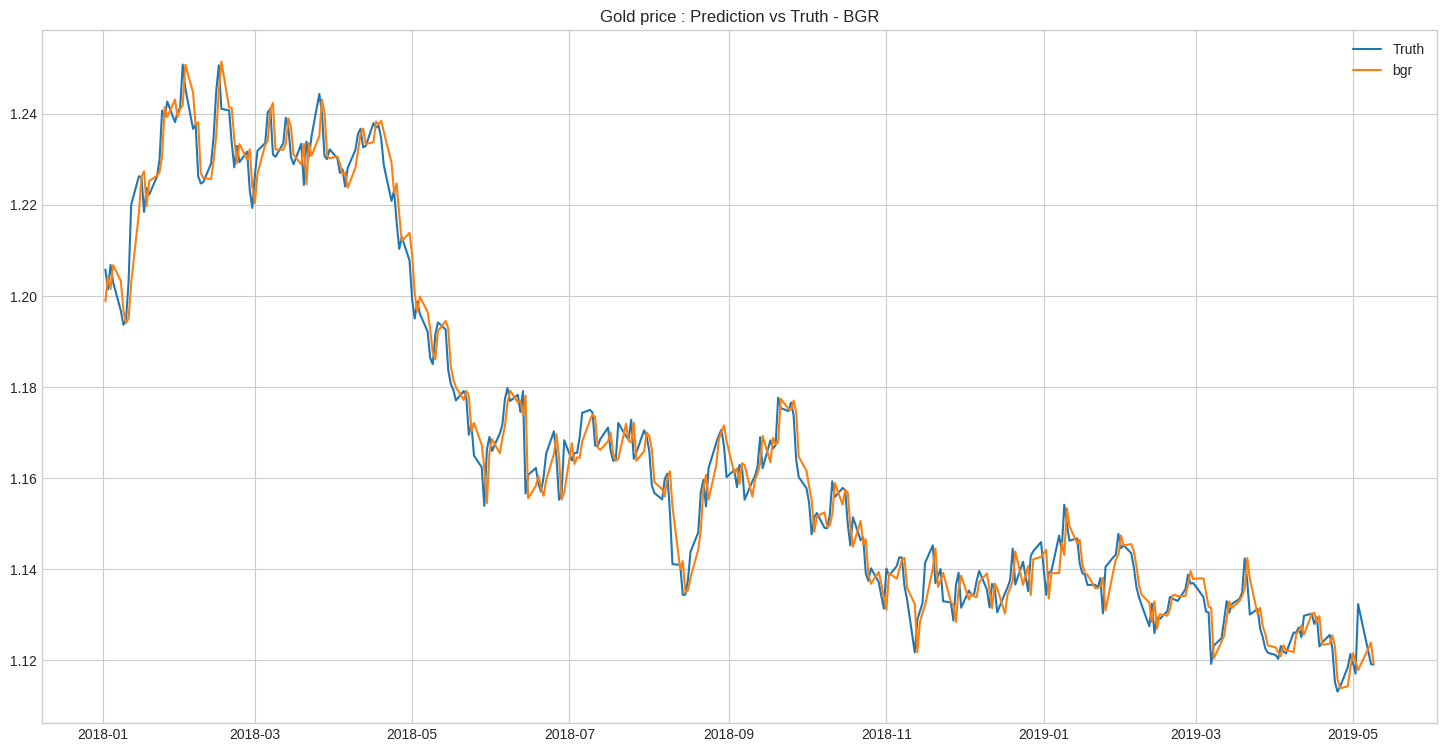

In [35]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_bgr, = plt.plot(dates, predictions_bgr)
plt.legend([plot_truth, plot_bgr], ['Truth', 'bgr'])
plt.title('Gold price : Prediction vs Truth - BGR')
plt.show()

In [36]:
param_grid = {
    "max_depth": [30, 50],
    "min_samples_split": [5, 10, 20],

}

rf = RandomForestRegressor(n_estimators=100)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
# print(grid_search.best_score_)

rf_best = grid_search.best_estimator_
predictions_rf = rf_best.predict(X_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_rf)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_rf)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_rf)))

{'max_depth': 50, 'min_samples_split': 10}
RMSE: 0.006
MAE: 0.005
R^2: 0.978


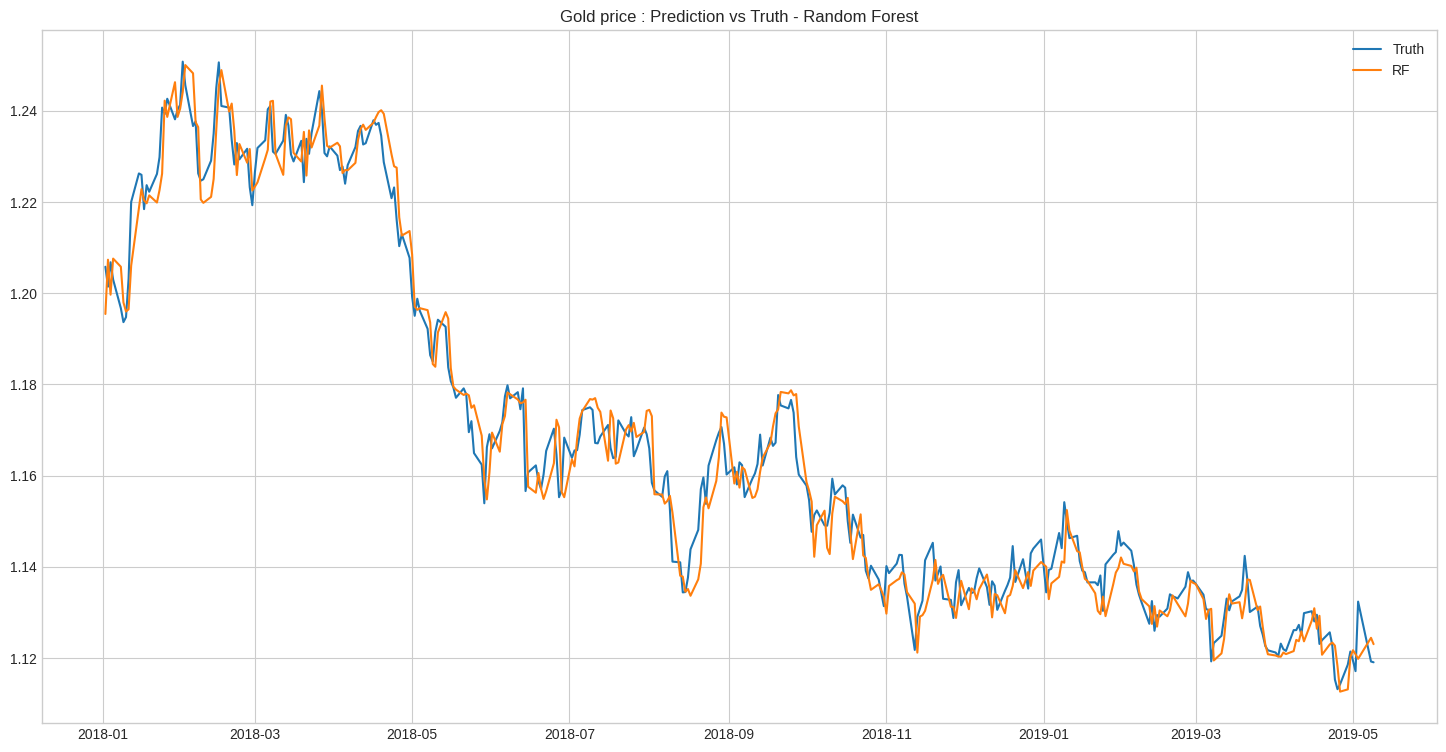

In [37]:
dates = data_test.index.values
plt.figure(figsize = (18,9))
plot_truth, = plt.plot(dates, y_test)
plot_rf, = plt.plot(dates, predictions_rf)
plt.legend([plot_truth, plot_rf], ['Truth', 'RF'])
plt.title('Gold price : Prediction vs Truth - Random Forest')
plt.show()

The model with the least mean_absolute_error:
 LIN    0.004008
dtype: float64


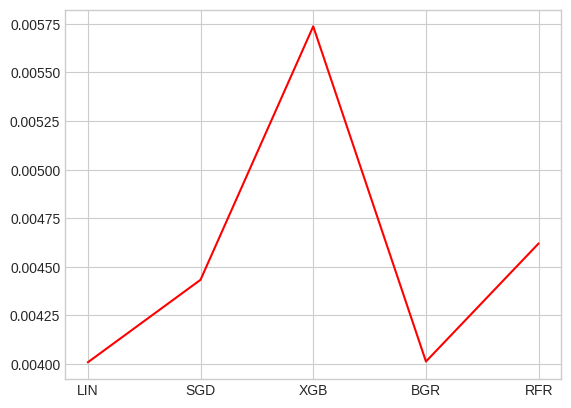

In [38]:
mae_scoring = pd.Series({'LIN':mean_absolute_error(y_test, predictions_lin),
                'SGD':mean_absolute_error(y_test, predictions_sgd),
                'XGB':mean_absolute_error(y_test, predictions_xgb),
                #'VTR':mean_absolute_error(y_test, predictions_vtr),
                'BGR':mean_absolute_error(y_test, predictions_bgr),
                'RFR':mean_absolute_error(y_test, predictions_rf)})

#filtering the regressor with the least mean_absolute_error value
filter = mae_scoring.min()
mae_min = mae_scoring[mae_scoring == mae_scoring.min()]
print('The model with the least mean_absolute_error:\n',mae_min)

plt.plot(mae_scoring, 'r')

In [39]:
#saving the BGR model with sklearn:joblib
joblib.dump(bgr, 'bgr_eurusd_10062019.pkl')

['bgr_eurusd_10062019.pkl']

In [40]:
#loading the saved model
model = joblib.load('bgr_eurusd_10062019.pkl')

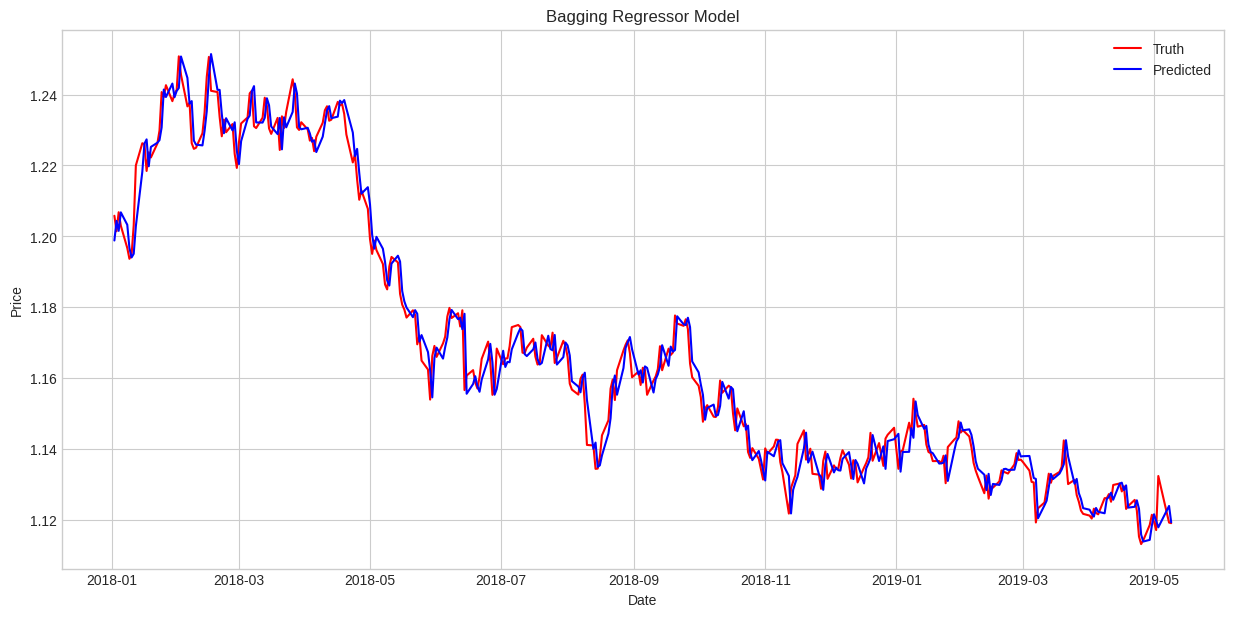

In [41]:
#Visualizing the predictions and truth values
pred = model.predict(X_scaled_test)
plt.figure(figsize=(15,7))
plt.plot(y_test, 'r', label='Truth')
plt.plot(y_test.index, pred, 'b', label='Predicted')
plt.title("Bagging Regressor Model")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

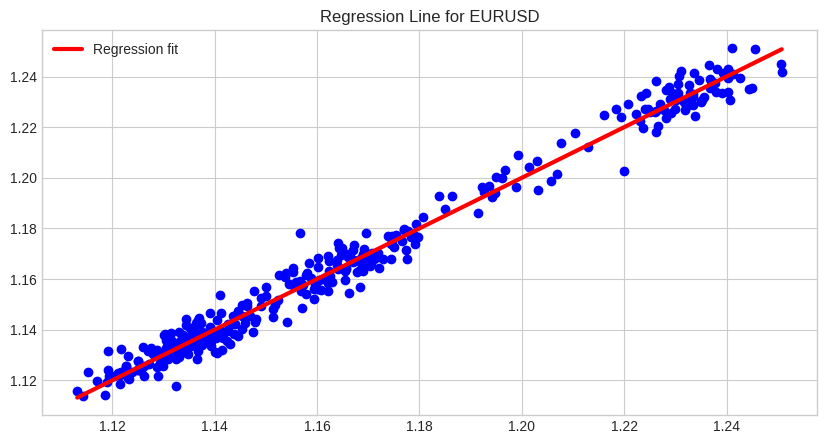

In [42]:
#plotting regression line
plt.style.use('seaborn-whitegrid')
plt.scatter(y_test, pred,color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=3, label='Regression fit')
fig = plt.gcf()
fig.set_size_inches(10,5)
plt.title("Regression Line for EURUSD")
plt.legend()
plt.show()

In [43]:
from flask import Flask,request,jsonify

In [47]:
import pickle
model =joblib.load(open('bgr_eurusd_10062019.pkl','rb'))
app = Flask(__name__)
@app.route('/')
def index():
    return "Hello world"
@app.route('/predict',methods=['POST'])
def predict():
    cgpa = request.form.get('cgpa')
    iq = request.form.get('iq')c
    profile_score = request.form.get('profile_score')
    input_query = np.array([[cgpa,iq,profile_score]])
    result = model.predict(input_query)[0]
    return jsonify({'placement':str(result)})
if __name__ == '__main__':
    app.run(debug=True)

SyntaxError: ignored